# **Laboratorio 5: Codigos de las señales EEG con Ultracortex Mark IV**

## 1. Importar Librerias

In [156]:
pip install mne


Note: you may need to restart the kernel to use updated packages.


In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne

## 2. Extracción de datos

Extraemos la data principal de nuestro dataframe, por ejemplo frecuencia de muestreo, numero de columnas (canales), numero de filas (muestras en el tiempo), nombre de las columnas y data en general.

In [158]:
import pandas as pd
import numpy as np
import mne

# === 1. CARGAR ARCHIVO ===
path = r"F:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\OpenBCI-RAW-2025.txt"
df = pd.read_csv(path, sep=",", comment="%", engine="python")

# === 2. LIMPIAR COLUMNAS ===
df.columns = df.columns.str.strip()  # elimina espacios
print(f"{df.shape[0]} filas x {df.shape[1]} columnas")
print(df.columns.tolist())

# === 3. CALCULAR FRECUENCIA DE MUESTREO ===
t = df["Timestamp"].values
dt = np.diff(t).mean()
fs_estimada = 1.0 / dt
print(f"Frecuencia de muestreo estimada: {fs_estimada:.2f} Hz")

# Usamos la frecuencia nominal de OpenBCI (Cyton)
fs = 250.0

# === 4. SELECCIONAR CANALES EEG ===
eeg_cols = [col for col in df.columns if col.startswith("EXG Channel")]
print("Canales EEG:", eeg_cols)

# Extraer datos y transponer a (n_channels, n_times)
data = df[eeg_cols].values.T
print("Forma del array de datos:", data.shape)  # (8, n_muestras)

# === 5. CREAR INFO PARA MNE ===
ch_names = eeg_cols
ch_types = ["eeg"] * len(ch_names)
info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=ch_types)

# === 6. CREAR OBJETO RAW ===
raw = mne.io.RawArray(data, info)
print(raw)

# === 7. RENOMBRAR CANALES A NOMENCLATURA ESTÁNDAR ===
# Correspondencia típica de OpenBCI Cyton 8ch → Sistema 10-20
rename_map = {
    "EXG Channel 0": "Fp1",
    "EXG Channel 1": "Fp2",
    "EXG Channel 2": "C3",
    "EXG Channel 3": "C4",
    "EXG Channel 4": "P7",
    "EXG Channel 5": "P8",
    "EXG Channel 6": "O1",
    "EXG Channel 7": "O2",
}

raw.rename_channels(rename_map)
print("Canales renombrados:", raw.ch_names)

# === 8. APLICAR MONTAGE ESTÁNDAR ===
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)
print("Montaje asignado correctamente.")


180227 filas x 25 columnas
['Sample Index', 'EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2', 'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6', 'EXG Channel 7', 'Accel Channel 0', 'Accel Channel 1', 'Accel Channel 2', 'Not Used', 'Digital Channel 0 (D11)', 'Digital Channel 1 (D12)', 'Digital Channel 2 (D13)', 'Digital Channel 3 (D17)', 'Not Used.1', 'Digital Channel 4 (D18)', 'Analog Channel 0', 'Analog Channel 1', 'Analog Channel 2', 'Timestamp', 'Marker Channel', 'Timestamp (Formatted)']
Frecuencia de muestreo estimada: 246.73 Hz
Canales EEG: ['EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2', 'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6', 'EXG Channel 7']
Forma del array de datos: (8, 180227)
Creating RawArray with float64 data, n_channels=8, n_times=180227
    Range : 0 ... 180226 =      0.000 ...   720.904 secs
Ready.
<RawArray | 8 x 180227 (720.9 s), ~11.0 MiB, data loaded>
Canales renombrados: ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', '

In [159]:
# === 9. VISUALIZAR SEÑALES ===
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, C3, C4, P7, P8, O1, O2
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


c:\Users\dell\anaconda3\envs\BCI-env\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


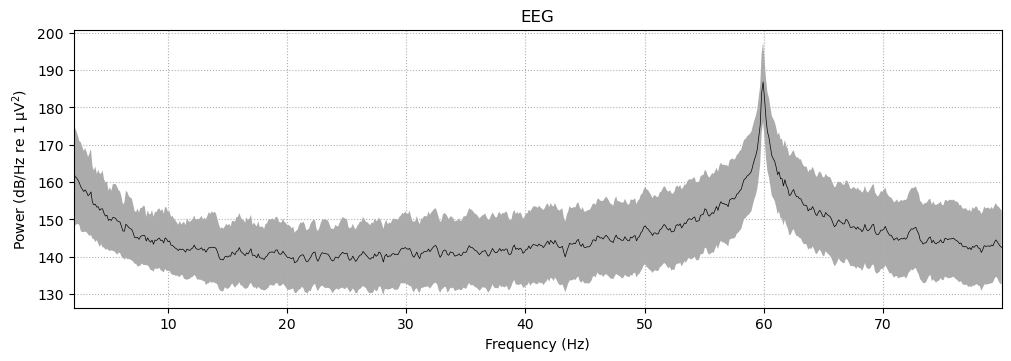

In [160]:
# === 10. VISUALIZAR PSD ===
raw.plot_psd(tmin=0, tmax=None, fmin=2, fmax=80, average=True, spatial_colors=False)

In [161]:
# === 11. CREAR EVOKED PARA TOPOGRAFÍA ===
# Usamos un promedio estático solo para visualizar
data_mean = np.mean(data, axis=1, keepdims=True)
evoked = mne.EvokedArray(data_mean, raw.info, tmin=0)
evoked.set_montage(montage)

<Evoked | '' (average, N=1), 0 – 0 s, baseline off, 8 ch, ~15 KiB>

In [162]:
data_mean = np.mean(data, axis=1, keepdims=True)  # promedio de cada canal
evoked = mne.EvokedArray(data_mean, raw.info, tmin=0)
evoked.set_montage(montage)

<Evoked | '' (average, N=1), 0 – 0 s, baseline off, 8 ch, ~15 KiB>

In [163]:
raw.load_data()
raw.filter(l_freq=1.0, h_freq=30.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)



<RawArray | 8 x 180227 (720.9 s), ~11.0 MiB, data loaded>

In [164]:
ica = mne.preprocessing.ICA(
    n_components=7, method="picard", max_iter="auto", random_state=97
)
ica.fit(raw)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 7 components
Fitting ICA took 34.7s.


Method,picard
Fit parameters,max_iter=500
Fit,332 iterations on raw data (180227 samples)
ICA components,7
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=7, n_times=180227
    Range : 0 ... 180226 =      0.000 ...   720.904 secs
Ready.


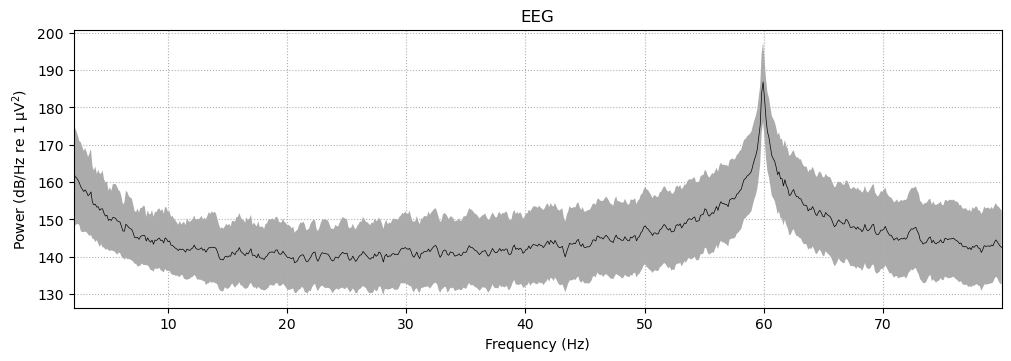

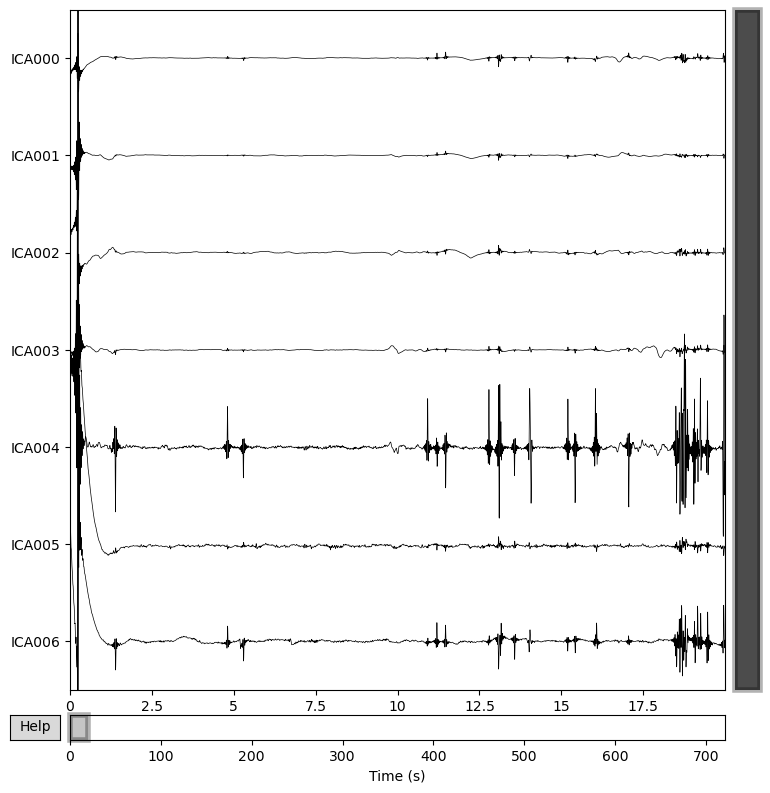

In [165]:
fig = ica.plot_sources(raw)

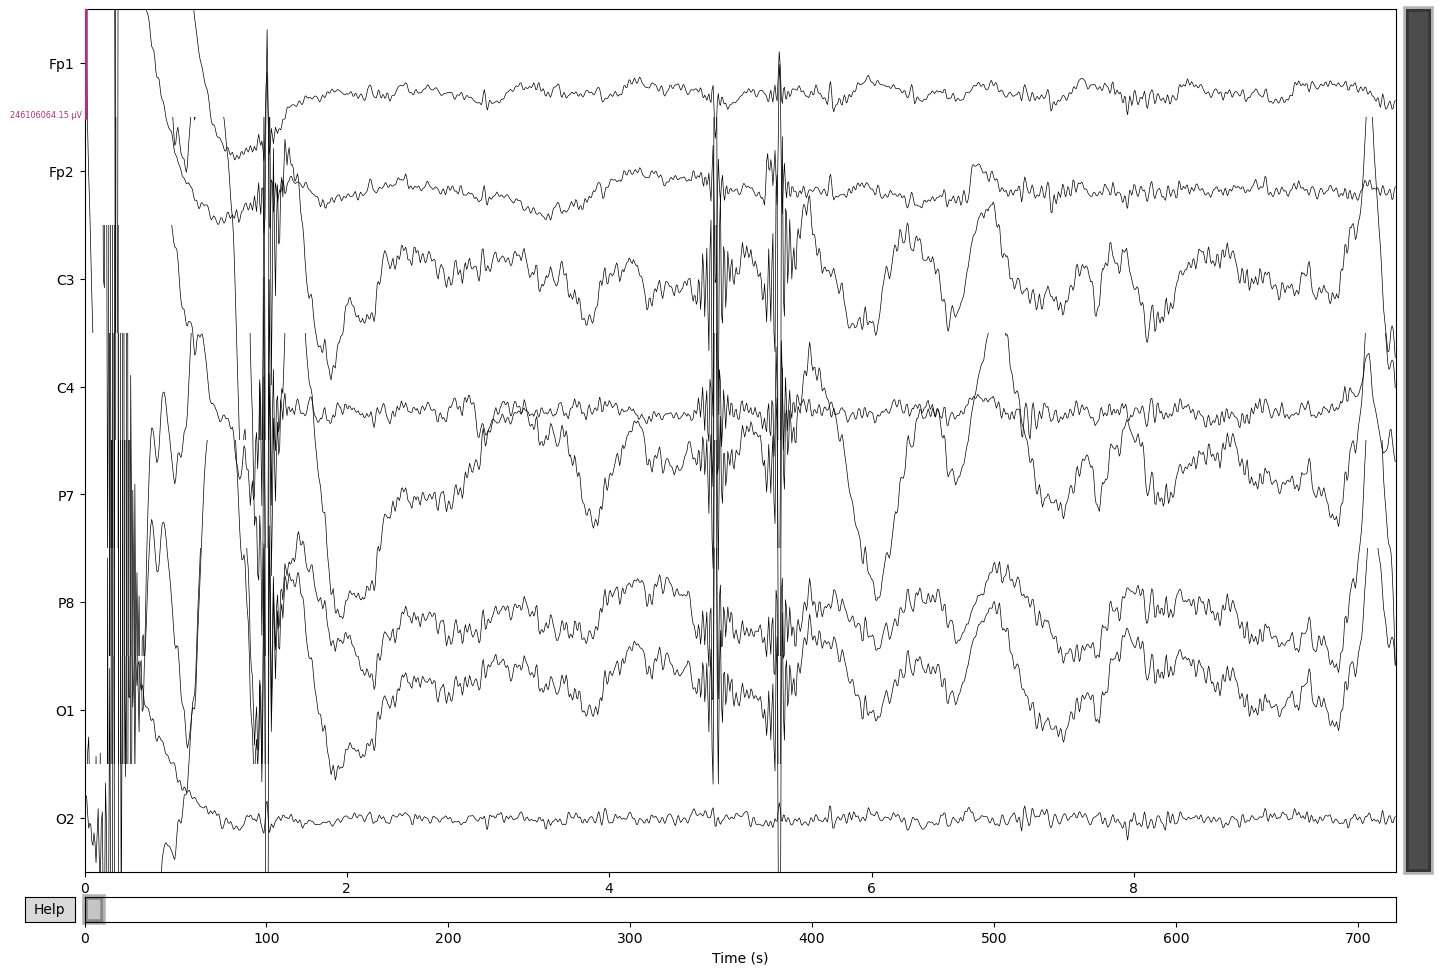

In [166]:
fig = raw.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated


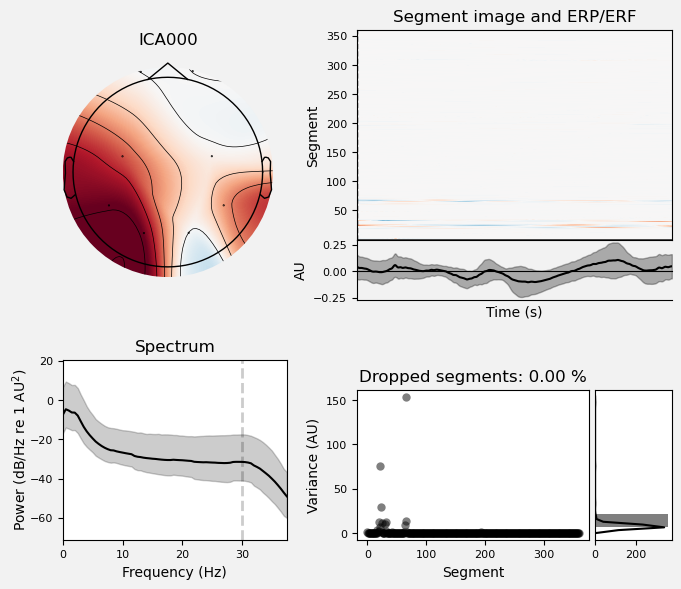

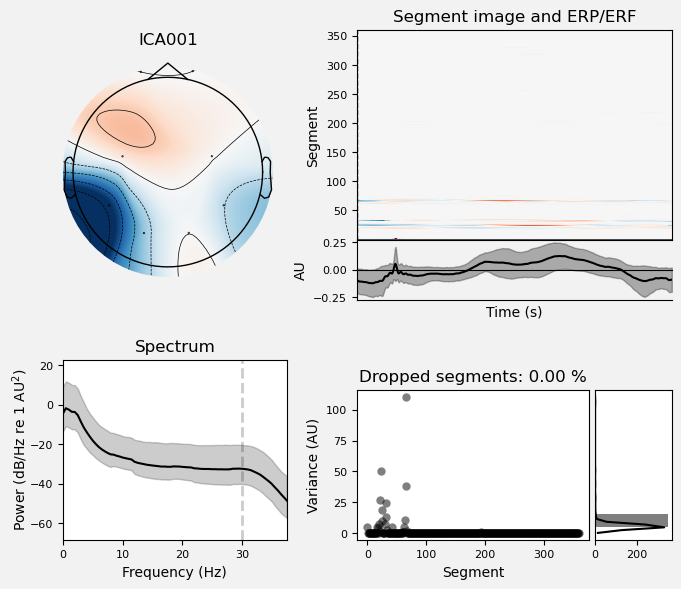

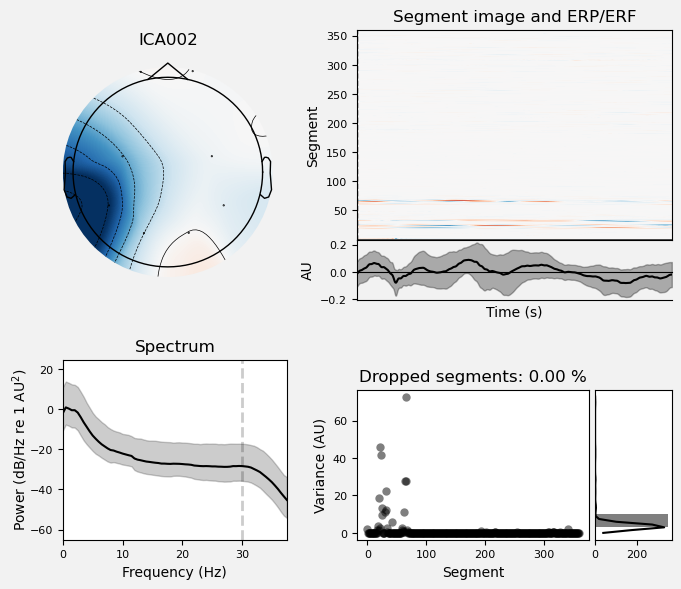

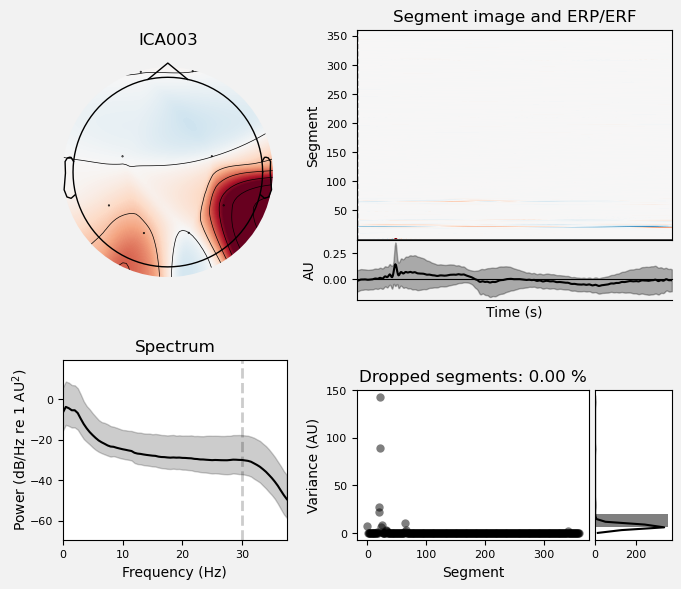

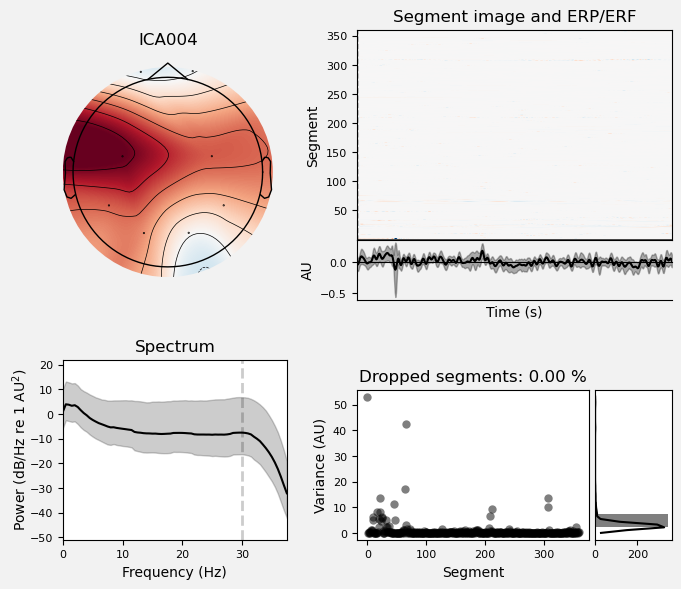

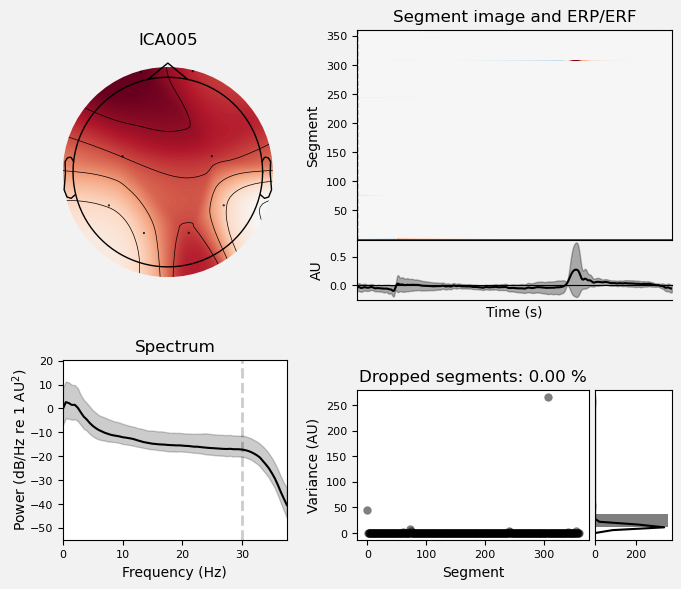

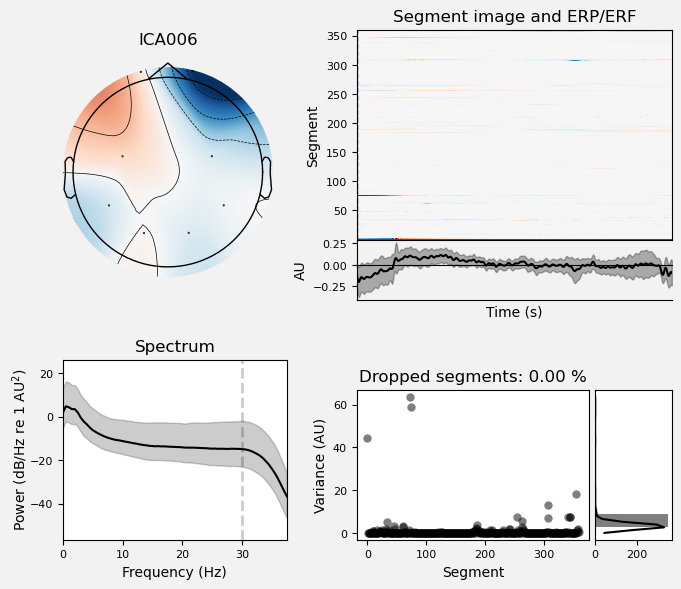

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [167]:
raw_clean = raw.copy()
ica.plot_properties(raw, picks=[0, 1, 2, 3, 4, 5, 6])

Criterios para decidir manualmente que componente ICA eliminar:
- Focos en los bordes de la corteza cerebral (musculos estan en el borde del craneo), si ves zonas rojas o azules intensas en los bordes
- Actividad muy localizada (Un punto fuerte de color intenso)

Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 3 ICA components
    Projecting back using 8 PCA components
Effective window size : 8.192 (s)


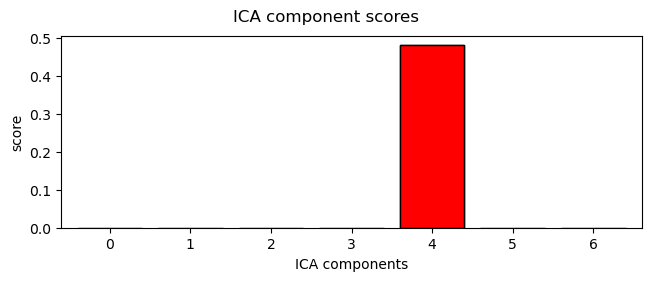

Manually found muscle artifact ICA components:      [4, 5, 6]
Automatically found muscle artifact ICA components: [4]


In [168]:
blink_idx = [4]
heartbeat_idx = [5]
muscle_idx = [6]
ica.apply(raw, exclude=blink_idx + heartbeat_idx + muscle_idx)
muscle_idx_auto, scores = ica.find_bads_muscle(raw)
ica.plot_scores(scores, exclude=muscle_idx_auto)
print(
    f"Manually found muscle artifact ICA components:      {blink_idx + heartbeat_idx + muscle_idx}\n"
    f"Automatically found muscle artifact ICA components: {muscle_idx_auto}"
)

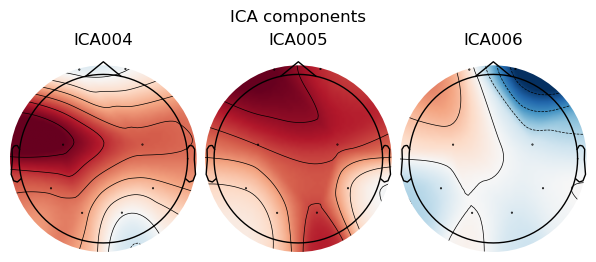

In [169]:
fig = ica.plot_components(picks=[4,5,6])

Concluimos diciendo que el unico componente a eliminar sera el 4to debido a que es con diferencia el que mas score tiene, manual y automaticamente. Ahora lo eliminamos

Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


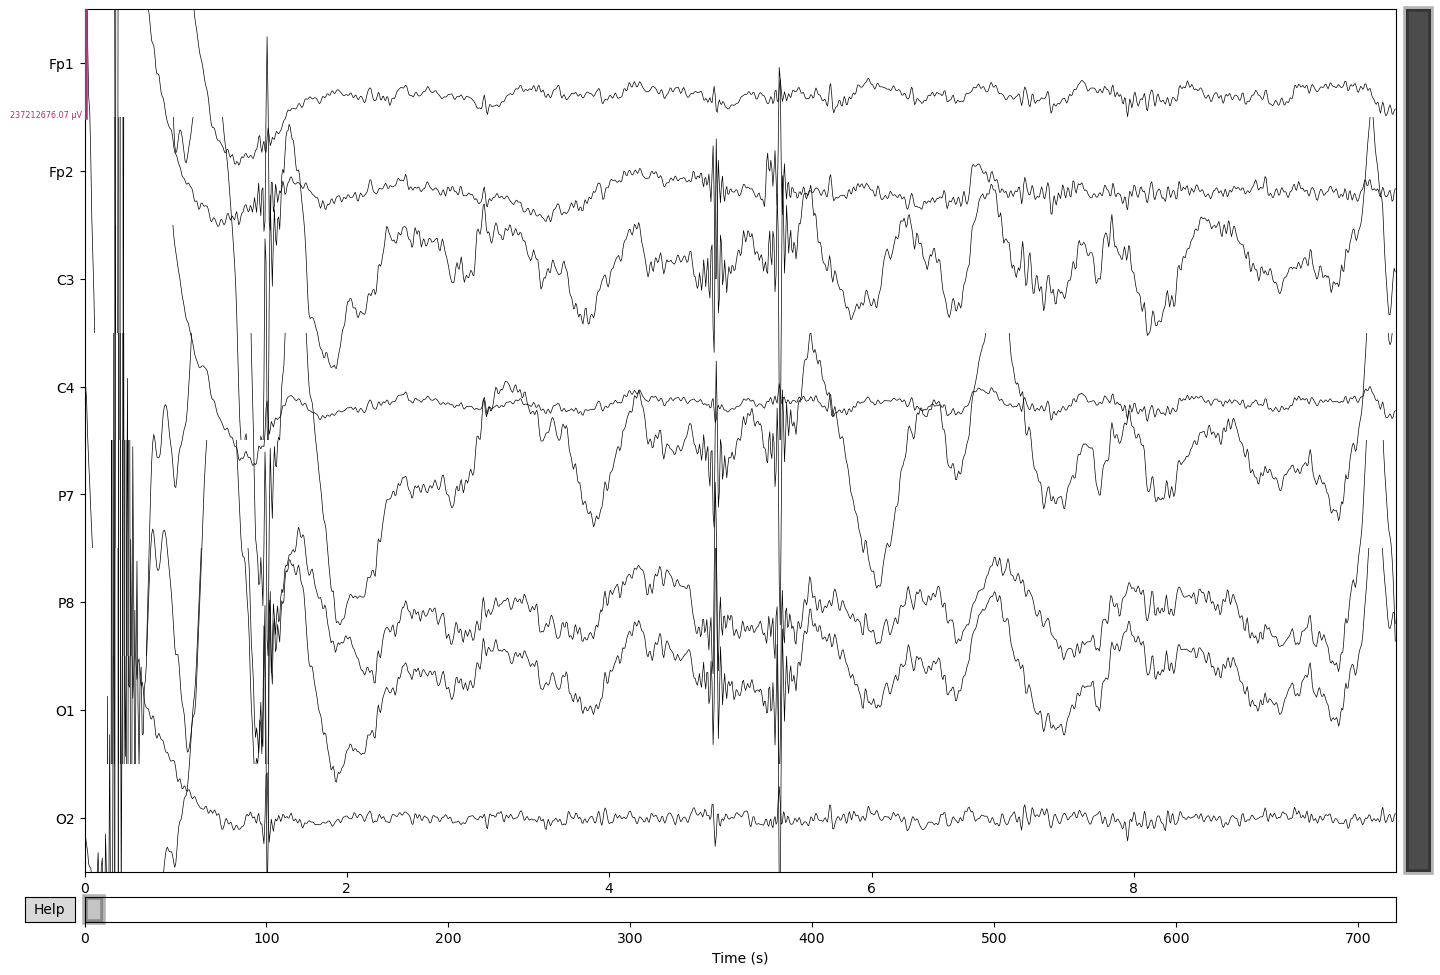

In [170]:
# === 2. Aplicar el ICA eliminando solo la componente 4 ===
ica.apply(raw_clean, exclude=[4])

# === 3. Graficar la señal reconstruida en el tiempo ===
fig = raw_clean.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)  # tamaño grande para ver los 8 canales
plt.show()